In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

# Basic LSTM Model


### Oil Price Data Processing

In [2]:
oil_price = pd.read_csv('DCOILWTICO.csv')
oil_price.head()

,DATE,DCOILWTICO
0,2012-01-03,102.96
1,2012-01-04,103.22
2,2012-01-05,101.81
3,2012-01-06,101.56
4,2012-01-09,101.31


In [3]:
oil_price.shape

(2086, 2)

In [4]:
# Convert string to Datetime
oil_price['DATE'] = pd.to_datetime(oil_price['DATE'])

In [5]:
# Process the oil price data, there are some '.' data in it
oil_price.loc[oil_price['DCOILWTICO'] == '.','DCOILWTICO'] = np.nan

# Fill the None with the last day's price
oil_price = oil_price.fillna(method='pad')

In [6]:
# Set time as index
oil_price = oil_price.set_index('DATE')
oil_price

,DCOILWTICO
DATE,
2012-01-03,102.96
2012-01-04,103.22
2012-01-05,101.81
2012-01-06,101.56
2012-01-09,101.31
...,...
2019-12-25,61.17
2019-12-26,61.72
2019-12-27,61.76


### Plot the oil price trend

<AxesSubplot:xlabel='DATE'>

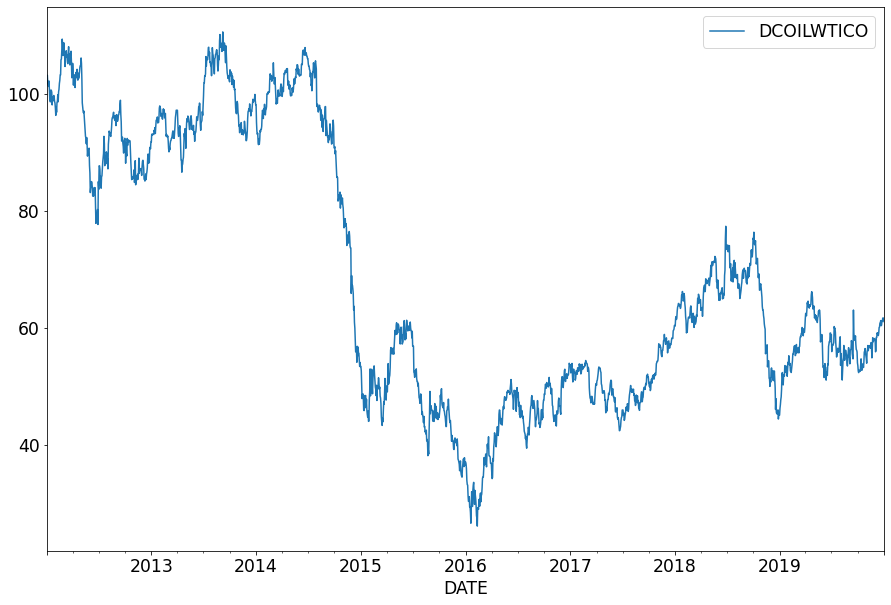

In [7]:
# Convert the price data type to 'float'
oil_price['DCOILWTICO'] = oil_price['DCOILWTICO'].astype(float)
oil_price.plot()

### Divide the dataset into train set and test set

In [8]:
train_size = int(len(oil_price) * 0.75)
test_size = len(oil_price) - train_size
train = oil_price.iloc[0:train_size]
test = oil_price.iloc[train_size: len(oil_price)]
display(len(train), len(test))

1564

522

### Normalisation of data

In [9]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler


# dcoilwtico_transformer = MinMaxScaler()
dcoilwtico_transformer = RobustScaler()
train['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(train[['DCOILWTICO']])
test['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(test[['DCOILWTICO']])

C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_14716\1347920800.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(train[['DCOILWTICO']])
C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_14716\1347920800.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['DCOILWTICO'] = dcoilwtico_transformer.fit_transform(test[['DCOILWTICO']])


### Construct the X_train, y_train, X_test, y_test with time_step=10

In [10]:
def create_dataset_LSTM(X, y, time_steps):
    Xs = []
    ys = []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
time_steps = 30
X_train, y_train = create_dataset_LSTM(train, train.DCOILWTICO, time_steps)
X_test, y_test = create_dataset_LSTM(test, test.DCOILWTICO, time_steps)
print(X_train.shape, y_train.shape)

(1534, 30, 1) (1534,)


### Build the LSTM model

In [12]:
from tensorflow import keras

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64, 
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
)

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error',optimizer='adam')

### Training the model

In [13]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=120, 
    batch_size=64, 
    validation_split=0.1, 
    shuffle=False
)

Epoch 1/120
22/22 [==============================] - 3s 39ms/step - loss: 0.0894 - val_loss: 0.0047
Epoch 2/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0109 - val_loss: 0.0030
Epoch 3/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0115 - val_loss: 0.0021
Epoch 4/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0018
Epoch 5/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 6/120
22/22 [==============================] - 0s 20ms/step - loss: 0.0086 - val_loss: 0.0020
Epoch 7/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0079 - val_loss: 0.0020
Epoch 8/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0019
Epoch 9/120
22/22 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 10/120
22/22 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0016

Epoch 80/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 5.9126e-04
Epoch 81/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0034 - val_loss: 7.9837e-04
Epoch 82/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 5.7988e-04
Epoch 83/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0041 - val_loss: 6.8383e-04
Epoch 84/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 6.3310e-04
Epoch 85/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 5.4478e-04
Epoch 86/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 5.8741e-04
Epoch 87/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0036 - val_loss: 6.0075e-04
Epoch 88/120
22/22 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 5.3749e-04
Epoch 89/120
22/22 [==============================] - 0

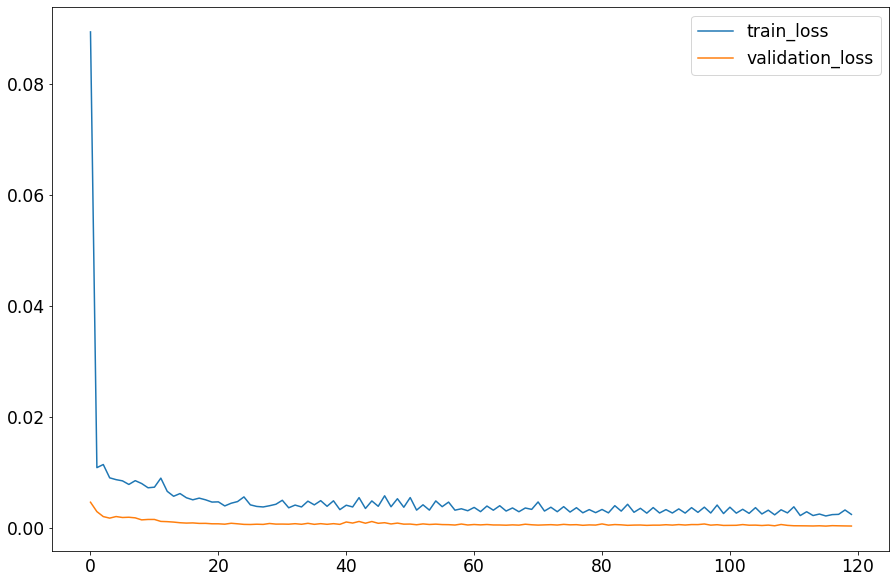

In [14]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()

### Model Prediction

In [15]:
y_pred = model.predict(X_test)

# Inverse normalisation of data
y_test_inv = dcoilwtico_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dcoilwtico_transformer.inverse_transform(y_pred)

16/16 [==============================] - 1s 3ms/step


### Results Visualization

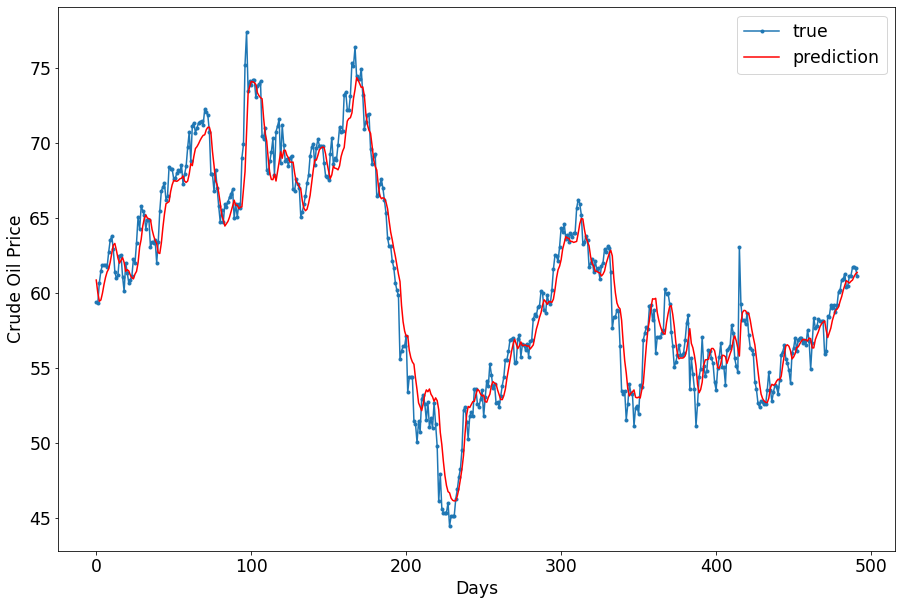

In [16]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Crude Oil Price')
plt.xlabel('Days')
plt.legend()
plt.show()


In [17]:
MSE = np.sum((y_test_inv.flatten()-y_pred_inv.flatten()) ** 2)/y_test_inv.shape[1]
MSE

2.4984308942851787

# LSTM Model with Sentiment Score

### Read News Headlines

In [18]:
news_head_df = pd.read_excel('Oil_News_Headlines.xlsx')
news_head_df.head()

,text,date
0,"Oil Dips as 2019 Ends; Big Gains on Year, Big ...","Dec 31, 2019"
1,Oil falls but on track for biggest yearly rise...,"Dec 31, 2019"
2,Russian firms divert oil from Belarus as no 20...,"Dec 31, 2019"
3,Global stocks end 2019 close to record highs,"Dec 31, 2019"
4,Oil prices set for biggest yearly rise since 2...,"Dec 30, 2019"


### Process the empty value

In [19]:
null_index = news_head_df.index[(news_head_df['date'] == ' ')]
news_head_df.drop(null_index, inplace=True)

### Change the format of the date

In [20]:
news_head_df['date'] = pd.to_datetime(news_head_df['date'], format = '%b %d, %Y')
news_head_df.head()

,text,date
0,"Oil Dips as 2019 Ends; Big Gains on Year, Big ...",2019-12-31
1,Oil falls but on track for biggest yearly rise...,2019-12-31
2,Russian firms divert oil from Belarus as no 20...,2019-12-31
3,Global stocks end 2019 close to record highs,2019-12-31
4,Oil prices set for biggest yearly rise since 2...,2019-12-30


### Calculate Sentiment Polarity

In [21]:
from textblob import TextBlob

# Calculate the sentiment score of a single headline
def get_sentiment(headline):
    blob = TextBlob(headline)
    return blob.sentiment.polarity

# Calculate the average sentiment score of the dataframe of a date
def get_average_sentiment(data_frame):
    score_list = []
    for index, values in data_frame.iterrows():
        polarity_score = get_sentiment(values['text'])
        score_list.append(polarity_score)
    return np.mean(score_list)  

In [22]:
# Obtain the Series of date
date_series = news_head_df['date'].drop_duplicates()
date_series = date_series.reset_index(drop=True)
date_series

0      2019-12-31
1      2019-12-30
2      2019-12-29
3      2019-12-27
4      2019-12-26
          ...    
2550   2012-01-06
2551   2012-01-05
2552   2012-01-04
2553   2012-01-03
2554   2012-01-01
Name: date, Length: 2555, dtype: datetime64[ns]

In [23]:
polarity_score_list = []
# Iterate the date Series
for value in date_series.values:
    df_corresponding_date = news_head_df[news_head_df['date'] == value]
    polarity_score = get_average_sentiment(df_corresponding_date)
    polarity_score_list.append(polarity_score)

score_series = pd.Series(polarity_score_list)
score_series

0       0.000000
1       0.019815
2       0.000000
3      -0.016667
4      -0.040000
          ...   
2550   -0.416667
2551   -0.091296
2552   -0.183125
2553   -0.341667
2554   -0.200000
Length: 2555, dtype: float64

### Construct the data frame with date and sentiment score

In [24]:
date_sentiment_df = pd.DataFrame({'DATE':date_series, 'SENTIMENT SCORE':score_series})
date_sentiment_df

,DATE,SENTIMENT SCORE
0,2019-12-31,0.000000
1,2019-12-30,0.019815
2,2019-12-29,0.000000
3,2019-12-27,-0.016667
4,2019-12-26,-0.040000
...,...,...
2550,2012-01-06,-0.416667
2551,2012-01-05,-0.091296
2552,2012-01-04,-0.183125
2553,2012-01-03,-0.341667


### Merge two date frames

In [25]:
oil_price_sentiment_df = pd.merge(oil_price, date_sentiment_df, on='DATE')
oil_price_sentiment_df = oil_price_sentiment_df.set_index('DATE')
oil_price_sentiment_df

,DCOILWTICO,SENTIMENT SCORE
DATE,,
2012-01-03,102.96,-0.341667
2012-01-04,103.22,-0.183125
2012-01-05,101.81,-0.091296
2012-01-06,101.56,-0.416667
2012-01-09,101.31,-0.420000
...,...,...
2019-12-24,61.17,-0.035417
2019-12-26,61.72,-0.040000
2019-12-27,61.76,-0.016667


### Build train set and test set

In [26]:
senti_train_size = int(len(oil_price_sentiment_df) * 0.75)
senti_test_size = len(oil_price_sentiment_df) - senti_train_size
senti_train, senti_test = oil_price_sentiment_df.iloc[0:senti_train_size], oil_price_sentiment_df.iloc[senti_train_size:len(oil_price_sentiment_df)]
print(len(senti_train), len(senti_test))

1551 518


### Data Pre-processing

In [27]:
# dcoi_transformer = MinMaxScaler()
dcoi_transformer = RobustScaler()
senti_train['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_train[['DCOILWTICO']])
senti_test['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_test[['DCOILWTICO']])

C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_14716\1873222913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti_train['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_train[['DCOILWTICO']])
C:\Users\Shiqi Wang\AppData\Local\Temp\ipykernel_14716\1873222913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti_test['DCOILWTICO'] = dcoi_transformer.fit_transform(senti_test[['DCOILWTICO']])


### Set the time_step

In [28]:
senti_time_steps = 30

X_train_senti, y_train_senti = create_dataset_LSTM(senti_train, senti_train.DCOILWTICO, senti_time_steps)
X_test_senti, y_test_senti = create_dataset_LSTM(senti_test, senti_test.DCOILWTICO, senti_time_steps)
print(X_train_senti.shape, y_train_senti.shape)


(1521, 30, 2) (1521,)


### Train the model with sentiment score as feature

In [29]:
model_senti = keras.Sequential()
model_senti.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=64, 
      input_shape=(X_train_senti.shape[1], X_train_senti.shape[2])
    )
  )
)

model_senti.add(keras.layers.Dropout(rate=0.2))
model_senti.add(keras.layers.Dense(units=1))
model_senti.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
history_senti = model_senti.fit(
    X_train_senti, y_train_senti, 
    epochs=200, 
    batch_size=64, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/200
22/22 [==============================] - 3s 35ms/step - loss: 0.1596 - val_loss: 0.0094
Epoch 2/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0827 - val_loss: 0.0046
Epoch 3/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0480 - val_loss: 0.0011
Epoch 4/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0080 - val_loss: 0.0016
Epoch 5/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 6/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0075 - val_loss: 0.0015
Epoch 7/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 8/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 9/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 10/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0014

Epoch 80/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 5.6317e-04
Epoch 81/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 6.8695e-04
Epoch 82/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 5.2843e-04
Epoch 83/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 7.6309e-04
Epoch 84/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 6.0263e-04
Epoch 85/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 6.6514e-04
Epoch 86/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 5.4377e-04
Epoch 87/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0037 - val_loss: 6.2762e-04
Epoch 88/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 5.4998e-04
Epoch 89/200
22/22 [==============================] - 0

22/22 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 4.9089e-04
Epoch 158/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0024 - val_loss: 4.1602e-04
Epoch 159/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 5.1077e-04
Epoch 160/200
22/22 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 4.1260e-04
Epoch 161/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 5.2439e-04
Epoch 162/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 4.3909e-04
Epoch 163/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 5.6690e-04
Epoch 164/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 4.1164e-04
Epoch 165/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 6.0585e-04
Epoch 166/200
22/22 [==============================] - 0s 13

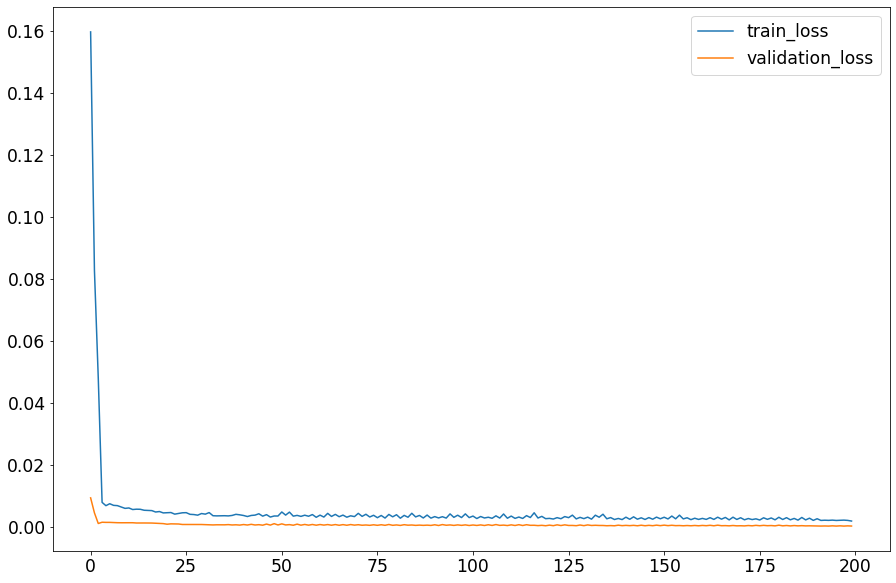

In [31]:
plt.plot(history_senti.history['loss'], label='train_loss')
plt.plot(history_senti.history['val_loss'], label='validation_loss')
plt.legend()

### Model Prediction

In [32]:
y_pred_senti = model_senti.predict(X_test_senti)

# Inverse normalisation of data
y_test_inv_senti = dcoi_transformer.inverse_transform(y_test_senti.reshape(1, -1))
y_pred_inv_senti = dcoi_transformer.inverse_transform(y_pred_senti)

16/16 [==============================] - 1s 4ms/step


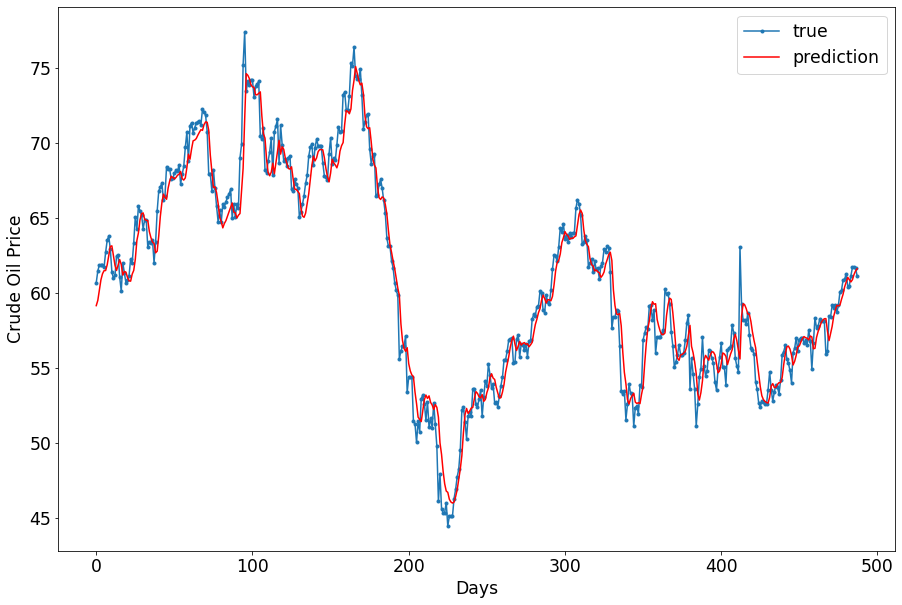

In [33]:
plt.plot(y_test_inv_senti.flatten(), marker='.', label="true")
plt.plot(y_pred_inv_senti.flatten(), 'r', label="prediction")
plt.ylabel('Crude Oil Price')
plt.xlabel('Days')
plt.legend()
plt.show()

In [34]:
MSE_senti = np.sum((y_test_inv_senti.flatten()-y_pred_inv_senti.flatten()) ** 2)/y_test_inv_senti.shape[1]
MSE_senti

2.055978140596802